# 🕹️ **Grid Training Notebook**

In this notebook, a training framework is developed which can train machine models on the ACIncome Task.




Furthermore, a dashboard is created which serves as an interface for the framework and allows the user to easily explore our collected metrics.

The purpose of this notebook is to allow students and researchers of AI fairness to explore how changes in temporal and/or spatial context can affect the fairness and performance of a model, as measured by various metrics. Recent research has shown that the interpretation of the fairness of classification models and datasets drastically depends on such context.

---
##⚙️ Setup Grid Training V2

⬇️ <font color='orange'>Click on the arrow below to run the setup!</font>

### ⚙️ Setup Data

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
#The Library that allows us to use the American Census Data and also offers the ACIncome Task
!pip install folktables

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for folktables: filename=folktables-0.0.11-py3-none-any.whl size=6779 sha256=7bed823eb8ffc8cf5a50ea48446c5cfaf453ba391aa9b257064eafede0890ecd
  Stored in directory: /root/.cache/pip/wheels/bd/63/b8/24d3f5d2c70002c68c1fe8e78e1de20fcbcb7a2ef3f56147b7
Successfully built folktables


In [ ]:
#Used for error correction of user input (state list)
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 2.9 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149874 sha256=64f922b7b96b543ac6890deed00ea997c664bb55c610240950872340f25c79ec
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
# needed for saving plotly plots
!pip install kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 124 kB/s 


**Define Dataset Helper Functions**

Label Data

In [ ]:
"""
function that labels numpy data (The output of the get_income_data_with_track function we defined) and returns a pandas Dataframe.
Most importantly it gives the 10 features their respective name.
"""

def label_numpy_data(data_array, labels=["AGEP","COW","SCHL","MAR","OCCP","POBP","RELP","WKHP","SEX","RAC1P"]):
  df = pd.DataFrame(data = data_array, columns = labels)
  return df


"""
Generate Pandas Dataframe from given inputs (of our get_income_data_with_track function). 
This will generate one huge dataframe that contains both the features and the label of the data.
This prepares the data for the conversion to AIF360 Binary Label Datasets.
"""

def Get_Dataframe_from_all(data_array, ground_truth, labels=["AGEP","COW","SCHL","MAR","OCCP","POBP","RELP","WKHP","SEX","RAC1P"]):
  df_label = pd.DataFrame(ground_truth,columns=['Label'])
  df_data = label_numpy_data(data_array,labels = labels)
  df = pd.concat([df_data,df_label],axis=1)
  return df

State Strings -> State Codes

In [ ]:
from Levenshtein import distance as levenshtein_distance

"""function that calculates the nearest state given an input string list (e.g. "washintong" would (hopefully) be mapped to "Washington" """
def calc_nearest_state(input_list):

  all_states_to_compare_to = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado","Connecticut","Delaware","District of Columbia","Florida","Georgia","Hawaii","Idaho","Illinois","Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana","Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York","North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania","Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah","Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming","Puerto Rico",]

  output_list = input_list.copy()

  for i in range(len(input_list)):
    cur_nearest_state = None
    cur_score = np.infty
    for state in all_states_to_compare_to:
      new_score = levenshtein_distance(input_list[i],state)
      if new_score<cur_score:
        cur_score = new_score
        cur_nearest_state = state

    output_list[i] = cur_nearest_state

  return output_list


"""
Example:
calc_nearest_state(["washingon","new macico"])
returns -> ['Washington', 'New Mexico']
"""

"""function that returns the state abbreviatian given the full name of a state."""


def get_state_code(states):
  state_code_list = []

  #define dict that given state name returns the state code
  state_name_to_code = {
      
      "Alabama" : "AL",
      "Alaska" : "AK",
      "Arizona" : "AZ",
      "Arkansas" : "AR",
      "California" : "CA",
      "Colorado" : "CO",
      "Connecticut" : "CT",
      "Delaware" : "DE",
      "District of Columbia" : "DC",
      "Florida" : "FL",
      "Georgia" : "GA",
      "Hawaii" : "HI",
      "Idaho" : "ID",
      "Illinois" : "IL",
      "Indiana" : "IN",
      "Iowa" : "IA",
      "Kansas" : "KS",
      "Kentucky" : "KY",
      "Louisiana" : "LA",
      "Maine" : "ME",
      "Maryland" : "MD",
      "Massachusetts" : "MA",
      "Michigan" : "MI",
      "Minnesota" : "MN",
      "Mississippi" : "MS",
      "Missouri" : "MO",
      "Montana" : "MT",
      "Nebraska" : "NE",
      "Nevada" : "NV",
      "New Hampshire" : "NH",
      "New Jersey" : "NJ",
      "New Mexico" : "NM",
      "New York" : "NY",
      "North Carolina" : "NC",
      "North Dakota" : "ND",
      "Ohio" : "OH",
      "Oklahoma" : "OK",
      "Oregon" : "OR",
      "Pennsylvania" : "PA",
      "Rhode Island" : "RI",
      "South Carolina" : "SC",
      "South Dakota" : "SD",
      "Tennessee" : "TN",
      "Texas" : "TX",
      "Utah" : "UT",
      "Vermont" : "VT",
      "Virginia" : "VA",
      "Washington" : "WA",
      "West Virginia" : "WV",
      "Wisconsin" : "WI",
      "Wyoming" : "WY",
      "Puerto Rico" : "PR",
  }
  for state in states:
    if len(str(state))==2:
      state_code_list.append(state)
    else:
      cur_state= calc_nearest_state([state])[0]
      state_code_list.append(state_name_to_code[cur_state])

  return state_code_list

In [ ]:
#Example:

get_state_code(["Ilaska", "Arizona", "California", "Colorado", "Hawaii", "Idaho", "Montana", "Nevada", "Naw Maxico", "Oregon", "Utah", "WA", "Wyoming"])

['AK', 'AZ', 'CA', 'CO', 'HI', 'ID', 'MT', 'NV', 'NM', 'OR', 'UT', 'WA', 'WY']

Generate Data

In [ ]:
"""function that gets the ACSIncome features, labels and group. While also returning a list of where each data point originated from"""

from folktables import ACSDataSource, ACSIncome, BasicProblem

def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    return df

"""
Our main function of generating data that we will use for our models.

Given a list of states and years it will download the relevant data and then return the wanted dataset(features),the labels, the group (Race) of each data sample and lists that contain the origin of the data (year, state).


"""

def get_income_data_with_track(states,years,threshold=50000,group_non_white=False,horizon='1-Year',survey='person'):
  """
  Inputs:
  states : list of strings (states)

  years : list of non-negative numbers in the range of 2014 - 2018 (years)

  threshold : non-negative number
  default value: 50000
  The threshold used for the ACIncome task. (Every data sample (income) above the threshold belongs to class 1 and every data sample (income) below the threshold belongs to class 0)

  group_non_white: Boolean
  default value: False
  Whether every non-white race should be relabeled as "Non-White" or not.
    If False: 9 Unique Race Values (1,2,3,4,5,6,7,8,9)
    If True:  2 Unique Race Values (-1,1)


  horizon='1-Year'
  Not relevant for a typical user, used as input for the folkstable library.

  survey='person'
  Not relevant for a typical user, used as input for the folkstable library.

  Returns:
  features : numpy array of arrays (the values of the features of each data sample, here 10 features)
  labels : numpy array of numbers (The class label of the data sample, see threshold)
  group : numpy array of numbers (The race of the data sample, see group_non_white)
  track_list_year : list of non-negative numbers in the range of 2014-2018 (years)
  track_list_state : list of strings (states)
  """
  for i in range(len(years)):
    years[i] = str(years[i])

  features = np.zeros((0,10))
  labels = np.zeros((0))
  group = np.zeros((0))
  track_list_year = []
  track_list_state = []

  states = get_state_code(states)

  IncomeProblem_own = BasicProblem(
      features=[
          'AGEP',
          'COW',
          'SCHL',
          'MAR',
          'OCCP',
          'POBP',
          'RELP',
          'WKHP',
          'SEX',
          'RAC1P',
      ],
      target='PINCP',
      target_transform=lambda x: x > threshold,
      group='RAC1P',
      preprocess=adult_filter,
      postprocess=lambda x: np.nan_to_num(x, -1),
    )

  for year in years:
    for state in states:
      data_source = ACSDataSource(survey_year=year, horizon=horizon, survey=survey)
      orig_data = data_source.get_data(states=[state], download=True)
      orig_features, orig_labels, orig_group = IncomeProblem_own.df_to_numpy(orig_data)

      if group_non_white==True:
        #1 stays 1 and everything else becomes -1
        orig_features[:,9] = 2*(orig_features[:,9]==1) -1
        orig_group = 2*orig_group[orig_group==1] -1

      features = np.concatenate((features, orig_features))
      labels = np.concatenate((labels, orig_labels))
      group = np.concatenate((group, orig_group))

      for i in range(len(orig_group)):
        track_list_year.append(int(year))
        track_list_state.append(state)


  return features,labels,group,track_list_year,track_list_state

### ⚙️ Setup Model

In [ ]:
!pip install aif360

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 5.2 MB/s 
     |████████████████████████████████| 25.9 MB 1.7 MB/s 
     |████████████████████████████████| 569 kB 47.9 MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=fddd05eecfaf88d1a2d9f7aff1f12f5842bea3b7c8c27208e173f9b2e39578cf
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.5.4 which is incompatible.


In [ ]:
!pip install -q fairlearn

     |████████████████████████████████| 177 kB 5.1 MB/s 


In [ ]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../")
from aif360.datasets import BinaryLabelDataset
#from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
# from aif360.metrics import BinaryLabelDatasetMetric
# from aif360.metrics import ClassificationMetric
# from aif360.metrics.utils import compute_boolean_conditioning_vector
#from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_compas, load_preproc_data_german
#from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
#from aif360.algorithms.inprocessing.meta_fair_classifier import MetaFairClassifier
#from sklearn.linear_model import LogisticRegression
#from sklearn.preprocessing import StandardScaler, MaxAbsScaler
#from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

import tensorflow as tf
tf.compat.v1.disable_eager_execution()


####  aif360  inprocessing models

Our focus to handle bias lies on **"In-processing"** algorithms which we took from the aif360 library.  
AI Fairness 360 (aif360) is a open source library containing techniques to detect and mitigate bias in datasets and models.  
In-processing algorithms are bias mitigation algorithms which are applied to a model during its training.  
We took used thre In-Processing techniques from the aif360 library whiche are AversialDebiasing, MetafairClassifier and Prejudice Remover.
For further information about the In-processing algorithms we linked the papers at the "References" paragraph of their description.

##### AdversialDebiasing

<font color='#3687bd'>class</font> **aif360.algorithms.inprocessing.AdversarialDebiasing**<font color='#3687bd'>(unprivileged_groups, privileged_groups, scope_name, sess, seed=None, adversary_loss_weight=0.1, num_epochs=50, batch_size=128, classifier_num_hidden_units=200, debias=True)</font>

Adversarial debiasing is an in-processing technique that learns a classifier to maximize prediction accuracy and simultaneously reduce an adversary’s ability to determine the protected attribute from the predictions [5]. This approach leads to a fair classifier as the predictions cannot carry any group discrimination information that the adversary can exploit.  

**Parameters:**
*   **unprivileged_groups** (<font color='#ab74c1'>tuple</font>) – Representation for unprivileged groups
*   **privileged_groups** (<font color='#ab74c1'>tuple</font>) – Representation for privileged groups  
*   **scope_name** (<font color='#ab74c1'>str</font>) – scope name for the tenforflow variable
*   **sess** (tf.Session) – tensorflow session
*   **seed** (<font color='#3687bd'>int</font>, optional) – Seed to make **predict** repeatable
*   **adversary_loss_weight** ((<font color='#3687bd'>float</font>, optional) – Hyperparameter that chooses the strength of the adversarial loss
*   **num_epochs** ((<font color='#3687bd'>int</font>, optional) – Number of training epochs
*   **batch_size** ((<font color='#3687bd'>int</font>, optional) – Batch size
*   **classifier_num_hidden_units** ((<font color='#3687bd'>int</font>, optional) – Number of hidden units in the classifier model
*   **debias** ((<font color='#3687bd'>bool</font>, optional) – Learn a classifier with or without debiasing  

**References**  
[5]	B. H. Zhang, B. Lemoine, and M. Mitchell, “Mitigating Unwanted Biases with Adversarial Learning,” AAAI/ACM Conference on Artificial Intelligence, Ethics, and Society, 2018.

**aif360 doc:**  
https://aif360.readthedocs.io/en/stable/modules/generated/aif360.algorithms.inprocessing.AdversarialDebiasing.html#id2

In [ ]:
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing

**Experience**  
The AdversialDebiasing algorithm has the option to learn a classifier with or without debiasing by setting the debias paramete to true or false which we used to compare the results.
We 
The run time of the model w
(Meta fair-> ~1,5 sec pro 10k
Adversial Debiasing -> ~15,1 Sec pro 10k
Prejudice Remover-> ~16,6 sec pro 10k 
- data set
- speed 
- besonderheite

##### MetafairClassifier

<font color='#3687bd'>class</font> **aif360.algorithms.inprocessing.MetaFairClassifier**<font color='#3687bd'>(tau=0.8, sensitive_attr='', type='fdr', seed=None)</font>

The meta algorithm here takes the fairness metric as part of the input and returns a classifier optimized w.r.t. that fairness metric [11]. 

**Parameters:**
*   **tau** (double, optional) – Fairness penalty parameter
*   **sensitive_attr** (<font color='#ab74c1'>str</font>, optional) – Name of protected attribute.  
*   **type** (<font color='#ab74c1'>str</font>, optional) – The type of fairness metric to be used. Currently “fdr” (false discovery rate ratio) and “sr” (statistical rate/disparate impact) are supported. To use another type, the corresponding optimization class has to be implemented.
*   **seed** (int, optional) – Random seed.

**References**  
[11]	L. E. Celis, L. Huang, V. Keswani, and N. K. Vishnoi. “Classification with Fairness Constraints: A Meta-Algorithm with Provable Guarantees,” 2018.


**aif360 doc:**  
https://aif360.readthedocs.io/en/stable/modules/generated/aif360.algorithms.inprocessing.MetaFairClassifier.html


In [ ]:
from aif360.algorithms.inprocessing.meta_fair_classifier import MetaFairClassifier

- ist nur auf

##### PrejudiceRemover

<font color='#3687bd'>class</font> **aif360.algorithms.inprocessing.PrejudiceRemover**<font color='#3687bd'>(eta=1.0, sensitive_attr='', class_attr='')</font>

Prejudice remover is an in-processing technique that adds a discrimination-aware regularization term to the learning objective [6].  

**Parameters:**
*   **eta** (double, optional) – fairness penalty parameter
*   **sensitive_attr** (<font color='#ab74c1'>str</font>, optional) – name of protected attribute  
*   **class_attr** (<font color='#ab74c1'>str</font>, optional) – label name

**References**  
[6]	T. Kamishima, S. Akaho, H. Asoh, and J. Sakuma, “Fairness-Aware Classifier with Prejudice Remover Regularizer,” Joint European Conference on Machine Learning and Knowledge Discovery in Databases, 2012.


**aif360 doc:**  
https://aif360.readthedocs.io/en/stable/modules/generated/aif360.algorithms.inprocessing.PrejudiceRemover.html


In [ ]:
from aif360.algorithms.inprocessing.prejudice_remover import PrejudiceRemover

### ⚙️ Setup Pickle

Pickle is a library that allows us to generate files out of complex variables.

We use it to save our train datasets and the predictions of the model.

In [ ]:
import pickle

### ⚙️ Setup Metrics

In this section, we setup the metrics that will be evaluated for each model. 
<br></br>
For that, we use all the metrics of `aif360.metrics.ClassificationMetric` ([docs](https://aif360.readthedocs.io/en/stable/modules/generated/aif360.metrics.ClassificationMetric.html)), which is a mix of performance and fairness related metrics. Additionally, we compute the ABROCA (actually just BROCA, since we do not take the absolute value to retain information about the favored group). Finally, we store all metrics in a csv-file, which will be used in our `metrics-visualization.ipynb` notebook.

ABROCA is a powerful fairness metric used in predictive modeling [proposed in 2019 by Gardner et. al](https://dl.acm.org/doi/10.1145/3303772.3303791), which is one of the main metrics we will use to assess model fairness throughout this project. It is formally defined as:

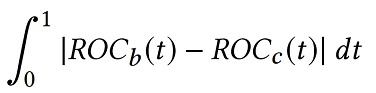

Another important metric for assessing fairness is Disparate Impact, which is defined in the `aif360` library. The formula for disparate impact is the following:

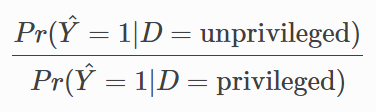

Still, it is important that we collect all the other metrics, too, as we want to allow the users to explore the collected metrics themselves.

In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score

# function to compute ABROCA given two datasets
def abroca(test_dataset, pred_dataset):
    df_test, _ = test_dataset.convert_to_dataframe()
    df_pred, _ = pred_dataset.convert_to_dataframe()

    df = pd.concat([df_test["Label"], df_pred["Label"], df_test["RAC1P"]],
                   axis=1,
                   keys=["gt", "pred", "race"])

    return compute_abroca(df)

# function to compute ABROCA given a dataframe with columns race, gt and pred
def compute_abroca(df):
    roc_auc_WHITE = roc_auc_score(y_true=df[df["race"] == 1]["gt"],
                              y_score=df[df["race"] == 1]["pred"])

    roc_auc_OTHER = roc_auc_score(y_true=df[df["race"] != 1]["gt"],
                              y_score=df[df["race"] != 1]["pred"])

    return roc_auc_WHITE - roc_auc_OTHER

In [ ]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric

import pickle
import csv

METRIC_NAMES = ['model_name',
                'abroca',
                'accuracy',
                'average_abs_odds_difference',
                'average_odds_difference',
                'base_rate',
                'between_all_groups_coefficient_of_variation',
                'between_all_groups_generalized_entropy_index',
                'between_all_groups_theil_index',
                'between_group_coefficient_of_variation',
                'between_group_generalized_entropy_index',
                'between_group_theil_index',
                'binary_confusion_matrix',
                'coefficient_of_variation',
                'consistency',
                'difference',
                'differential_fairness_bias_amplification',
                'disparate_impact',
                'equal_opportunity_difference',
                'error_rate',
                'error_rate_difference',
                'error_rate_ratio',
                'false_discovery_rate',
                'false_discovery_rate_difference',
                'false_discovery_rate_ratio',
                'false_negative_rate',
                'false_negative_rate_difference',
                'false_negative_rate_ratio',
                'false_omission_rate',
                'false_omission_rate_difference',
                'false_omission_rate_ratio',
                'false_positive_rate',
                'false_positive_rate_difference',
                'false_positive_rate_ratio',
                'generalized_binary_confusion_matrix',
                'generalized_entropy_index',
                'generalized_false_negative_rate',
                'generalized_false_positive_rate',
                'generalized_true_negative_rate',
                'generalized_true_positive_rate',
                'mean_difference',
                'negative_predictive_value',
                'num_false_negatives',
                'num_false_positives',
                'num_generalized_false_negatives',
                'num_generalized_false_positives',
                'num_generalized_true_negatives',
                'num_generalized_true_positives',
                'num_instances',
                'num_negatives',
                'num_positives',
                'num_pred_negatives',
                'num_pred_positives',
                'num_true_negatives',
                'num_true_positives',
                'performance_measures',
                'positive_predictive_value',
                'power',
                'precision',
                'ratio',
                'recall',
                'rich_subgroup',
                'selection_rate',
                'sensitivity',
                'smoothed_empirical_differential_fairness',
                'specificity',
                'statistical_parity_difference',
                'theil_index',
                'true_negative_rate',
                'true_positive_rate',
                'true_positive_rate_difference']

def compute_metrics(test_dataset,
                    prediction_dataset,
                    unprivileged_groups=[{'RAC1P': 2,'RAC1P': 3,'RAC1P': 4,'RAC1P': 5,'RAC1P': 6,'RAC1P': 7,'RAC1P': 8,'RAC1P': 9}],
                    privileged_groups=[{'RAC1P': 1}],
                    write_csv=True,
                    csv_name="metrics.csv",
                    model_name="<no model name>"):
    """
    Given BinaryLabelDatasets test_dataset and prediction_dataset, compute all
    AIF360 ClassificationMetrics and optionally store them in a .csv file.

    Additionally, return a dictionary of all metrics.
    """

    # create ClassificationMetric object with test set and predictions
    # the object will include all metrics, see link below
    # https://aif360.readthedocs.io/en/stable/modules/generated/aif360.metrics.ClassificationMetric.html

    classification_metrics = ClassificationMetric(test_dataset,
                                                  prediction_dataset,
                                                  unprivileged_groups,
                                                  privileged_groups)

    metric_values = []

    # compute all metrics specified in METRIC_NAMES
    for metric_name in METRIC_NAMES[2:]:
        try:
            loc = {"classification_metrics": classification_metrics}
            exec(f"value = classification_metrics.{metric_name}()", globals(), loc)
            metric_values.append(loc["value"])
        except TypeError:
            metric_values.append(None)

    # insert ABROCA
    metric_values.insert(0, abroca(test_dataset, prediction_dataset))

    # insert model name
    metric_values.insert(0, model_name)

    # dictionary of all metrics in name:value format
    metrics_dict = dict(zip(METRIC_NAMES, metric_values))

    # write metrics to .csv file, if enabled
    if write_csv:
        with open(csv_name, 'w', encoding='utf8') as f:
            writer = csv.writer(f)
            writer.writerow(METRIC_NAMES)
            writer.writerow(metric_values)

    return metrics_dict

### ⚙️ Setup US Region Plotting

In [ ]:
import plotly.express as px
import pandas as pd
import numpy as np
import random
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from Levenshtein import distance as levenshtein_distance

In [ ]:
def plot_us_states(state_codes, file_name=None):
    """
    Generate a plot of given US states.

    Args:
        state_codes (list of str): State codes to plot.
        file_name (str, optional): File name for generated plot. Defaults to None,
                                   which means that the plot does not get saved.
    """
    
    states_values = [[state, random.rand()] for state in state_codes]
    df = pd.DataFrame(states_values, columns=['state_code', 'value'])
    fig = px.choropleth(df,
                        locations='state_code',
                        locationmode='USA-states',
                        scope='usa',
                        color='value')

    fig.update_coloraxes(showscale=True)

    if file_name is not None:
        fig.write_image(file_name)

    fig.show()

In [ ]:
def plot_us_regions_and_states(regions, metric_values, metric=None, infos=None, file_name_pre=None):
    """
    Generate a plot of all regions together and a single plot for every region.

    Args:
        regions (list of str): region codes to plot.
        metric_values (list of int): the values for the metric
        metric (str): name of the used metric changes the used color range
          possibilitys: "accuracy", "abroca", "f1score", "disparate impact"
          if none -> "Viridis" will be used as colorscale and the range will be
          the min and max value from metric_vales
        infos (dict): a dictionary with information about the plots
          example dict {trained_dataset = 'west coast geo',
                        year = 2015,
                        threshold = 500000,
                        test_dataset = ['rural','west coast geo'],
                        model_name = 'Metafair'}
        file_name_pre (str, optional): adds a prefix to the generated filenames 
    """
    plot_us_states_cholormap(regions, metric_values, metric=metric, infos=infos, file_name_pre=file_name_pre)
    plot_us_regions2(regions, metric_values, metric=metric, infos=infos, file_name_pre=file_name_pre)



In [ ]:
def plot_us_regions2(regions, metric_values, metric=None, infos=None, file_name_pre=None):
    """
    Generate a single plot for every given US region.

    Args:
        regions (list of str): region codes to plot.
        metric_values (list of int): the values for the metric
        metric (str): name of the used metric changes the used color range
          possibilitys: "accuracy", "abroca", "f1score", "disparate impact"
          if none -> "Viridis" will be used as colorscale and the range will be
          the min and max value from metric_vales
        infos (dict): a dictionary with information about the plots
          example dict {trained_dataset = 'west coast geo',
                        year = 2015,
                        threshold = 500000,
                        test_dataset = ['rural','west coast geo'],
                        model_name = 'Metafair'}
        file_name_pre (str, optional): adds a prefix to the generated filenames
    """
    states = regions_to_states(regions)
    state_code_regions = []
    for state_region in states:
      state_code_regions.append(get_state_code(state_region))
    color_continuous_midpoint = None
    continous_scale = "Viridis"
    metric_name = metric
    if not metric:
      range_color = [min(metric_values),max(metric_values)]
      metric_name = "value"
    elif metric == "accuracy":
      range_color = [0,1]
      continous_scale = "RdYlGn"
    elif metric == "abroca":
      range_color = [-1,1]
      continous_scale = "PuOr"
      color_continuous_midpoint=0
    elif metric == "f1score":
      continous_scale = "RdYlGn"
      range_color = [0,1]
    elif metric == "disparate impact":
      continous_scale = "PuOr"
      range_color = [0,2]
      color_continuous_midpoint=1
    else:
      range_color = [min(metric_values),max(metric_values)]
    figures= []
    for count, state_code_region in enumerate(state_code_regions):
      states_values = []
      for state_code in state_code_region:
        states_values.append([state_code, metric_values[count],regions[count]])
      df = pd.DataFrame(states_values, columns=['state_code', metric_name,'regions'])
      if not infos:
        title = regions[count]
      else:
        title=""
        title = title + "Trained " + infos["model_name"]+ " "+ "on date from"+ " "+ infos["year"]+ " "+ "with a threshold of" + " " +infos["threshold"]+"<br>"
        title = title + "Train Dataset: " + infos["trained_dataset"]+ "<br>"
        title = title + "Test Dataset: " + regions[count] + " "
      fig = px.choropleth(df,
                          locations='state_code',
                          locationmode='USA-states',
                          scope='usa',
                          color= metric_name,
                          range_color= range_color,
                          color_continuous_scale=continous_scale,
                          color_continuous_midpoint=color_continuous_midpoint,
                          hover_data=[metric_name, 'regions'],
                          title=title)
      fig.update_coloraxes(showscale=True)
      figures.append(fig)
    for count, f in enumerate(figures):
      file_name= ""
      if file_name_pre is not None:
        file_name = file_name_pre+ "_"
      if infos is not None:
        file_name = file_name + infos["model_name"]+ "_"+  infos["trained_dataset"]+ "_"+ infos["year"]+ "_"+infos["threshold"]+"_"+ regions[count] + "_"+ infos["year"]+ "_"+infos["threshold"]
      else:
        file_name = file_name + regions[count]
      file_name = file_name + ".png"
      f.write_image(file_name)
      f.show()


In [ ]:
def plot_us_states_cholormap(regions, metric_values, metric=None, infos=None, file_name_pre=None, ):
    """
    Generate a plot of given US regions.

    Args:
        regions (list of str): region codes to plot.
        metric_values (list of int): the values for the metric
        metric (str): name of the used metric changes the used color range
          possibilitys: "accuracy", "abroca", "f1score", "disparate impact"
          if none -> "Viridis" will be used as colorscale and the range will be
          the min and max value from metric_vales
        infos (dict): a dictionary with information about the plots
          example dict {trained_dataset = 'west coast geo',
                        year = 2015,
                        threshold = 500000,
                        test_dataset = ['rural','west coast geo'],
                        model_name = 'Metafair'}
        file_name_pre (str, optional): adds a prefix to the generated filenames
    """
    states = regions_to_states(regions)
    state_code_regions = []

    for state_region in states:
      state_code_regions.append(get_state_code(state_region))
    color_continuous_midpoint=None
    continous_scale = "Viridis"
    metric_name = metric
    if not metric:
      range_color = [min(metric_values),max(metric_values)]
      metric_name = "value"
    elif metric == "accuracy":
      range_color = [0,1]
      continous_scale = "RdYlGn"
    elif metric == "abroca":
      range_color = [-1,1]
      continous_scale = "PuOr"
      color_continuous_midpoint=0
    elif metric == "f1score":
      continous_scale = "RdYlGn"
      range_color = [0,1]
    elif metric == "disparate impact":
      continous_scale = "PuOr"
      range_color = [0,2]
      color_continuous_midpoint=1
    else:
      range_color = [min(metric_values),max(metric_values)]
    if not infos:
      title = "all selected data sets (mean values)"
    else:
      title=""
      title = title + "Trained " + infos["model_name"]+ " "+ "on date from"+ " "+ infos["year"]+ " "+ "with a threshold of" + " " +infos["threshold"]+"<br>"
      title = title + "Train Dataset: " + infos["trained_dataset"]+ "<br>"
      title = title + "Test Dataset: " + ", ".join(regions)+ " "
    states_values = []
    state_code_dict = {}
    for count, state_code_region in enumerate(state_code_regions):
      for state_code in state_code_region:
        if state_code in state_code_dict.keys():
          state_code_dict[state_code].append((metric_values[count],regions[count]))
        else:
          state_code_dict[state_code]= [(metric_values[count],regions[count])]
    for key_state_code in state_code_dict.items():
      state_code_regions= []
      values=[]
      for value_region_tuple in key_state_code[1]:
        values.append(value_region_tuple[0])
        state_code_regions.append(value_region_tuple[1])
      mean = sum(values)/len(key_state_code[1])
      states_values.append([key_state_code[0], mean, state_code_regions, values])
    df = pd.DataFrame(states_values, columns=['state_code', metric_name,'regions', 'values'])
    fig = px.choropleth(df,
                        locations='state_code',
                        locationmode='USA-states',
                        scope='usa',
                        color=metric_name,
                        color_continuous_scale=continous_scale,
                        color_continuous_midpoint=color_continuous_midpoint,
                        range_color= range_color,
                        hover_data=[metric_name, 'regions', 'values'],
                        title=title
                        )
    fig.update_coloraxes(showscale=True)
    file_name = ""
    if file_name_pre is not None:
      file_name = file_name_pre + "_"
    regions_name = "_".join(regions)
    if infos is not None:
      file_name = file_name + infos["model_name"]+ "_"+  infos["trained_dataset"]+ "_"+ infos["year"]+ "_"+infos["threshold"]+"_"+ regions_name + "_"+ infos["year"]+ "_"+infos["threshold"]
    else:
      file_name = file_name +  regions_name
    file_name = file_name + ".png"
    fig.write_image(file_name)
    fig.show()

In [ ]:
def regions_to_states(regions: list):
  """ Gets regions and returns the euqivalent states for the regions

  Args:
      regions (list): gets a list of regions

  Returns:
      list: gives a list of list where every list stand for a region with his states

  Example:
      regions_to_states(['west coast geo', 'urban']) ->  [['Alaska', 'California', 'Hawaii', 'Oregon', 'Washington'],['California ','New Jersey ',...]]
  """
  states = []
  for cur_dataset in regions:
      #Determine current state list according to dataset preset
      if cur_dataset == 'west coast geo':
        states.append(["Alaska", "California", "Hawaii", "Oregon", "Washington"])
      elif cur_dataset == 'west coast wiki':
        states.append(["Alaska", "Arizona", "California", "Colorado", "Hawaii", "Idaho", "Montana", "Nevada", "New Maxiko", "Oregon", "Utah", "Washington", "Wyoming"])
      elif cur_dataset == 'east coast geo':
        states.append(["Maine", "New Hampshire", "Massachusetts", "Rhode Island", "Connecticut", "New York", "New Jersey", "Delaware", "Maryland", "Virginia", "North Carolina", "South Carolina", "Georgia", "Florida"])
      elif cur_dataset == 'none coast geo':
        states.append(["Alabama", "Arkansas", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Michigan", "Minnesota", "Mississippi", "Missouri", "Nebraska", "North Dakota", "Ohio", "Oklahoma", "Pennsylvania", "South Dakota", "Tennessee", "Texas", "Vermont", "West Virginia", "Wisconsin", "Puerto Rico", "Colorado", "Wyoming", "Montana", "Idaho", "Utah", "Nevada", "Arizona", "New Mexiko"])
      elif cur_dataset == 'none coast wiki':
        states.append(["Alabama", "Arkansas", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Michigan", "Minnesota", "Mississippi", "Missouri", "Nebraska", "North Dakota", "Ohio", "Oklahoma", "Pennsylvania", "South Dakota", "Tennessee", "Texas", "Vermont", "West Virginia", "Wisconsin", "Puerto Rico", "Colorado", "Wyoming", "Montana", "Idaho", "Utah", "Nevada", "Arizona", "New Mexiko"])
      elif cur_dataset == 'urban':
        states.append(["California ","New Jersey ","Nevada ","Puerto Rico ","Massachusetts ","Hawaii ","Florida","Rhode Island ","Utah ","Arizona ","Illinois ","Connecticut ","New York ","Maryland ","Colorado ","Texas ","Washington ","Delaware ","Oregon "])
      elif cur_dataset == 'rural':
        states.append(["Pennsylvania", "Ohio", "New Mexico", "Virginia", "Georgia", "Michigan", "Kansas", "Minnesota", "Louisiana", "Nebraska", "Indiana", "Idaho", "Missouri", "Wisconsin", "Tennessee", "South Carolina", "Oklahoma", "North Carolina", "Alaska", "Wyoming", "Iowa", "New Hampshire", "North Dakota", "Alabama", "Kentucky", "South Dakota", "Arkansas", "Montana", "Mississippi", "West Virginia", "Vermont", "Maine", ])
      elif cur_dataset == 'north':
        states.append(["Washington","Oregon","Idaho","Montana","Wyoming","North Dakota","South Dakota","Nebraska","Minnesota","Iowa","Wisconsin","Illinois","Michigan","Indiana","Ohio","Pennslyvania","New York","Vermont","New Hampshire","Maine","Massasuchets","Conniticet","New Jersey"])
      elif cur_dataset == 'south':
        states.append(["California","Nevada","Utah","Arizona","New Mexico","Colorado","Texas","Oklahoma","Kansas","Arkansas","Missouri","Louisana","Missisipi","Alabama","Tenesee","Kentucky","Georgia","Florida","South Carolina","North Carolina","Virginia","West Virginia","Delaware","Maryland"])
      elif cur_dataset == 'all':
        states.append(["California","Nevada","Utah","Arizona","New Mexico","Colorado","Texas","Oklahoma","Kansas","Arkansas","Missouri","Louisana","Missisipi","Alabama","Tenesee","Kentucky","Georgia","Florida","South Carolina","North Carolina","Virginia","West Virginia","Delaware","Maryland","Washington","Oregon","Idaho","Montana","Wyoming","North Dakota","South Dakota","Nebraska","Minnesota","Iowa","Wisconsin","Illinois","Michigan","Indiana","Ohio","Pennslyvania","New York","Vermont","New Hampshire","Maine","Massasuchets","Conniticet","New Jersey"])
      else: 
        states.append([])
  return states

### ⚙️ Setup Helper functions

Imports and helper functions that are not directly related to machine learning etc.

In [ ]:
import sys, os

"""
deafen can be used to reduce the output a function call generates.
This is especially useful for the AIF360 models, as they don't have an inherent verbose parameter.
"""

def deafen(function, *args):
    real_stdout = sys.stdout
    sys.stdout = open(os.devnull, "w")
    output = function(*args)
    sys.stdout = real_stdout
    return output

##Credit Kamron Bhavnagri from Stackoverflow

In [ ]:
import sys
import random

### ⚙️ Setup Grid Training

**The main function of our training framework.**

It combines every previously introduced method into one singular call. 

Given all of the parameters, the method will train the selected model(s) on the selected data with all of the relevant parameters set as defined.

How?
Summary:

      *   Check inputs
      *   Download and generate all selected datasets
      *   Split data into train and test sets (Holdout Testing)
      *   Save every train dataset
      Repeat for every model:
        Repeat for every year:
          Repeat for every threshold:
            Repeat for every train dataset:
              *   Train model on the dataset
              *   Predict data for every dataset using trained model
              *   Evaluate the predictions -> generate metrics
              *   Save predictions and metrics
      * If verbose is high enough: output plot of selected metric
        

Why in this way?

This ensures that all datasets are evaluated fairly. 

It also allows uhe user to the directly if the results are dependent on the direction 
(e.g. maybe model from 2014 works better than a model from 2018 on data from 2018, but is this also the case for the data from 2014? We can check this easily)

It also allows the user to be really flexible in what they want, without an extensive list of inputs. 
E.g. if the user had to add every test dataset individually it would reduce readibility and discourages users from experimenting as the syntax would be too complex.

Each execution of this function generates a lot of data, however depending on what the user is interested in many things can be overlooked (Still the possibility of using it is already provided)



In [ ]:
"""
EXAMPLE PARAMETERS
datasets = ['west coast geo','east coast geo', 'none coast geo', 'urban','rural','north','south','all']

years = ['2014','2015','2016','2017','2018','2014 2015 2016']

models = ['adversial debiasing']

thresholds = ['50000']

group_non_white = False

verbose = 1

seed = 12681

metric = 'accuracy'

file_prefix = None

"""


def grid_train_model_v2(datasets : list,years : list, models : list,thresholds = ['50000'],group_non_white = False,verbose=1,seed = 12681, metric='accuracy',file_prefix=None):
  """
  Given a list of datasets, a list of years, a list of models, and optionally a list of thresholds, a list of additional paramaters and a boolean for grouping none whites,
    the function trains all of the models on all of the datasets in accordance with the years, threshold and the none white grouping.

  Args:
      datasets (list of strings): List of datasets that should be evaluated. Each Model is trained on one of the datasets and evaluated on all datasets. Supported presets = 'west coast geo','west coast wiki','east coast geo','none coast geo','none coast wiki','urban','rural','north','south','all'
      years (list of strings): List of years of the datasets. Possible values are 2014-2018 (inclusive) and also a combination of different years separated by a space. e.g. '2014' or '2014 2015 2016'
      models (list of strings): List of models that should be evaluated. Each Model is trained both fairness aware and unaware. Supported models = 'adversial debiasing'
      threshholds (list of strings, optional): List of thresholds that should be used to determine the labels of the datasets. By default it is ['50000'], the split used by the 'Adult Dataset' 
      parameters (list, optional): list of parameters that should be given to the models. Currently not used.
      group_non_white(Bool,optional): Boolean Value that decides if non-white heritages are either grouped together or not. RAC1P = [-1,1] if True, RAC1P = [1,2,3,4,5,6,7,8,9] if False

  Outputs:
      Preds_'model'_'debias'_'trained dataset'_'years'_'threshold'_'tested dataset'_'years'_'threshold'_'group non-white'(pickled BinaryLabelDatasets): Both the predictions 

  Returns:
      (list): predctions
      (list): labels
      (list): groups

  ----------------------------------------------------------------
      datasets
      Possible Values: ['west coast geo','east coast geo', 'none coast geo', 'urban','rural','north','south','all']

      Subgroup of our supported datasets. Every dataset as a single string.
      years 
      Possible Values: ['2014','2015','2016','2017','2018','2014 2015 2016']

      Every Year from 2014 - 2018 (inclusive) or a subgroup of those years. Everything as a single string

      models 
      Possible Values: ['adversial debiasing', 'Metafair','PrejudiceRemover']

      Subgroup of our supported Models. Every model as a single string.

      Threshold 
      Possible Values: Any nonnegative number. Number should be a string. 
      Reasonable numbers could be: 30000,40000,50000 etc.

      group_non_white
      Possible Values: [True, False]

      Whether every non-white race should be relabeled as "Non-White" or not.
      If False: 9 Unique Race Values
      If True:  2 Unique Race Values

      verbose
      Possible Values: [0,1,2]

      Determines how much output the User receives during the training. 
      0 = no outputs, 1 = medium amount of output, 2 = high amount of output

      seed
      Possible Values: Any Number

      Used as the initalization for the random number generation (e.g. affects the train-test split of the data)

      metric
      Possible Values: ['accuracy','f1score','abroca','disparate impact']

      Determines the metric used for an overview plot at the end. The plot shows the value of the metric for the last trained model on every dataset (in the last year + threshold).

      file_prefix
      Possible Values: Any String

      The prefix for the filename of the generated plots
      """

  #Assert Datasets are as intended
  assert datasets is not None
  supported_sets = ['west coast geo','west coast wiki','east coast geo','none coast geo','none coast wiki','urban','rural','north','south','all']
  for cur_dataset in datasets:
    assert cur_dataset in supported_sets 

  #Assert years are as intended
  assert years is not None
  supported_years = ['2014','2015','2016','2017','2018']
  for cur_years in years:
    splitted_years = cur_years.split()
    for year in splitted_years:
      assert year in supported_years

  #Assert models are as intended
  assert models is not None
  supported_models = ['adversial debiasing', 'Metafair','PrejudiceRemover']
  for cur_model in models:
    assert cur_model in supported_models


  #Assert thresholds can be transformed into integers
  assert thresholds is not None
  for i in range(len(thresholds)):
    threshold = thresholds[i]
    try:
      thresholds[i] = int(threshold)
    except TypeError as err:
      print('Error in Transformation:',err)


  print('Now starting the Grid Training')

  """
  Dataset Section
  """

  list_of_all_datasets_train = []
  list_of_all_datasets_test = []
  name_of_datasets = []
  list_of_years = []
  list_of_thresholds = []

  for cur_dataset in datasets:
    #Determine current state list according to dataset preset
    if cur_dataset == 'west coast geo':
      state_list = ["Alaska", "California", "Hawaii", "Oregon", "Washington"] 
    elif cur_dataset == 'west coast wiki':
      state_list = ["Alaska", "Arizona", "California", "Colorado", "Hawaii", "Idaho", "Montana", "Nevada", "New Maxiko", "Oregon", "Utah", "Washington", "Wyoming"] 
    elif cur_dataset == 'east coast geo':
      state_list = ["Maine", "New Hampshire", "Massachusetts", "Rhode Island", "Connecticut", "New York", "New Jersey", "Delaware", "Maryland", "Virginia", "North Carolina", "South Carolina", "Georgia", "Florida"]
    elif cur_dataset == 'none coast geo':
      state_list = ["Alabama", "Arkansas", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Michigan", "Minnesota", "Mississippi", "Missouri", "Nebraska", "North Dakota", "Ohio", "Oklahoma", "Pennsylvania", "South Dakota", "Tennessee", "Texas", "Vermont", "West Virginia", "Wisconsin", "Puerto Rico", "Colorado", "Wyoming", "Montana", "Idaho", "Utah", "Nevada", "Arizona", "New Mexiko"]
    elif cur_dataset == 'none coast wiki':
      state_list = ["Alabama", "Arkansas", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Michigan", "Minnesota", "Mississippi", "Missouri", "Nebraska", "North Dakota", "Ohio", "Oklahoma", "Pennsylvania", "South Dakota", "Tennessee", "Texas", "Vermont", "West Virginia", "Wisconsin", "Puerto Rico", "Colorado", "Wyoming", "Montana", "Idaho", "Utah", "Nevada", "Arizona", "New Mexiko"]
    elif cur_dataset == 'urban':
      state_list = ["California ","New Jersey ","Nevada ","Puerto Rico ","Massachusetts ","Hawaii ","Florida","Rhode Island ","Utah ","Arizona ","Illinois ","Connecticut ","New York ","Maryland ","Colorado ","Texas ","Washington ","Delaware ","Oregon "]
    elif cur_dataset == 'rural':
      state_list = ["Pennsylvania", "Ohio", "New Mexico", "Virginia", "Georgia", "Michigan", "Kansas", "Minnesota", "Louisiana", "Nebraska", "Indiana", "Idaho", "Missouri", "Wisconsin", "Tennessee", "South Carolina", "Oklahoma", "North Carolina", "Alaska", "Wyoming", "Iowa", "New Hampshire", "North Dakota", "Alabama", "Kentucky", "South Dakota", "Arkansas", "Montana", "Mississippi", "West Virginia", "Vermont", "Maine", ]
    elif cur_dataset == 'north':
      state_list = ["Washington","Oregon","Idaho","Montana","Wyoming","North Dakota","South Dakota","Nebraska","Minnesota","Iowa","Wisconsin","Illinois","Michigan","Indiana","Ohio","Pennslyvania","New York","Vermont","New Hampshire","Maine","Massasuchets","Conniticet","New Jersey"]
    elif cur_dataset == 'south':
      state_list = ["California","Nevada","Utah","Arizona","New Mexico","Colorado","Texas","Oklahoma","Kansas","Arkansas","Missouri","Louisana","Missisipi","Alabama","Tenesee","Kentucky","Georgia","Florida","South Carolina","North Carolina","Virginia","West Virginia","Delaware","Maryland"]
    elif cur_dataset == 'all':
      state_list = ["California","Nevada","Utah","Arizona","New Mexico","Colorado","Texas","Oklahoma","Kansas","Arkansas","Missouri","Louisana","Missisipi","Alabama","Tenesee","Kentucky","Georgia","Florida","South Carolina","North Carolina","Virginia","West Virginia","Delaware","Maryland","Washington","Oregon","Idaho","Montana","Wyoming","North Dakota","South Dakota","Nebraska","Minnesota","Iowa","Wisconsin","Illinois","Michigan","Indiana","Ohio","Pennslyvania","New York","Vermont","New Hampshire","Maine","Massasuchets","Conniticet","New Jersey"]
    else: 
      state_list = []

    for cur_years in years:
      #Get the current combination of years
      splitted_years = cur_years.split()

      for threshold in thresholds:
        """
        if verbose == 0:
          features_orig,labels_orig,group_orig,track_list_year_orig,track_list_state_orig = deafen(get_income_data_with_track,state_list,splitted_years,threshold,roup_non_white)
        if verbose == 1:
          print('-------------------------------------------------')
          print('Creating dataset:',str(cur_dataset))
          print('-------------------------------------------------')
          features_orig,labels_orig,group_orig,track_list_year_orig,track_list_state_orig = deafen(get_income_data_with_track,state_list,splitted_years,threshold,group_non_white)
        if verbose == 2:
          features_orig,labels_orig,group_orig,track_list_year_orig,track_list_state_orig = get_income_data_with_track(state_list,splitted_years,threshold=threshold,group_non_white=group_non_white)
        """

        print('-------------------------------------------------')
        print('Creating dataset:',str(cur_dataset).replace(" ", "_") + str(splitted_years))
        print('-------------------------------------------------')
        features_orig,labels_orig,group_orig,track_list_year_orig,track_list_state_orig = get_income_data_with_track(state_list,splitted_years,threshold=threshold,group_non_white=group_non_white)

        df_all_orig = Get_Dataframe_from_all(features_orig,labels_orig)

        df_features = label_numpy_data(features_orig)

        aif_dataset = BinaryLabelDataset(df= df_all_orig,label_names = ["Label"],protected_attribute_names =['RAC1P'],privileged_protected_attributes = [1])

        split_value= 0.7  # splits the data set into train and test data
        dataset_orig_train, dataset_orig_test = aif_dataset.split([split_value], shuffle=True,seed=seed)

        list_of_all_datasets_train.append(dataset_orig_train)
        list_of_all_datasets_test.append(dataset_orig_test)
        name_of_datasets.append(cur_dataset)
        list_of_years.append(cur_years)
        list_of_thresholds.append(threshold)


        """
        Pickle Datasets
        """

        filename = 'Dataset_' + str(cur_dataset).replace(" ", "_") + '_' + str(cur_years) + '_' + str(threshold) + 'group_non_white_' + str(group_non_white) + '.pickle'
        outfile = open(filename,'wb')

        pickle.dump(dataset_orig_test,outfile)
        outfile.close()

        if verbose == 2:
          print('-------------------------------------------------')
          print('Finished pickling the dataset:',str(cur_dataset))
          print('-------------------------------------------------')

  """
  Print the datasets and lists obtained
  """

  #print('list_of_all_datasets_train',list_of_all_datasets_train)
  #print('list_of_all_datasets_test',list_of_all_datasets_test)
  #print('name_of_datasets',name_of_datasets)
  #print('list_of_years',list_of_years)
  #print('list_of_thresholds',list_of_thresholds)


  if verbose == 1 or verbose == 2:
    print('-------------------------------------------------')
    print('Finished creating the datasets')
    print('-------------------------------------------------')

  """
  Model section
  """
  #privileged_group = []

  #unprivileged_group = []

  if group_non_white == False:
    privileged_groups = [{'RAC1P': 1}]
    unprivileged_groups = [{'RAC1P': 2,'RAC1P': 3,'RAC1P': 4,'RAC1P': 5,'RAC1P': 6,'RAC1P': 7,'RAC1P': 8,'RAC1P': 9}]
  if group_non_white == True:
    privileged_groups = [{'RAC1P': 1}]
    unprivileged_groups = [{'RAC1P': -1}]

  list_of_metrics_from_last_model = []
  list_of_datasets_for_last_model = []

  if metric == 'disparate impact':
    metric_key = 'disparate_impact'
  else:
    metric_key = metric

  for cur_dataset_num in range(len(name_of_datasets)):
    for cur_model in models:
      if cur_model == 'adversial debiasing':
        """
        First learn the debiased model
        """
        sess = tf.compat.v1.Session()

        cur_name = 'adv_deb_'+ str(name_of_datasets[cur_dataset_num]).replace(" ", "_")+ str(list_of_years[cur_dataset_num]) + str(list_of_thresholds[cur_dataset_num]) +  '_debias' + str(random.randrange(1,10000))
        
        debias_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                      unprivileged_groups = unprivileged_groups,
                      scope_name=cur_name,
                      debias=True,
                      sess=sess)

        #print(list_of_all_datasets_train[cur_dataset_num])

        if verbose == 0:
          deafen(debias_model.fit,list_of_all_datasets_train[cur_dataset_num])
        if verbose == 1:
          print('-------------------------------------------------')
          print('Now starting training of adv. Deb. --- debiased model on dataset:' + str(name_of_datasets[cur_dataset_num]) + str(list_of_years[cur_dataset_num]) + str(list_of_thresholds[cur_dataset_num]))
          print('-------------------------------------------------')
          deafen(debias_model.fit,list_of_all_datasets_train[cur_dataset_num])
        if verbose == 2:
          debias_model.fit(list_of_all_datasets_train[cur_dataset_num])

        """
        Second learn the biased model
        """

        cur_name = 'adv_deb_'+ str(name_of_datasets[cur_dataset_num]).replace(" ", "_") + str(list_of_years[cur_dataset_num]) + str(list_of_thresholds[cur_dataset_num]) + '_bias' + str(random.randrange(1,10000))
        
        bias_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                      unprivileged_groups = unprivileged_groups,
                      scope_name=cur_name,
                      debias=False,
                      sess=sess)

        if verbose == 0:
          deafen(bias_model.fit,list_of_all_datasets_train[cur_dataset_num])
        if verbose == 1:
          print('-------------------------------------------------')
          print('Now starting training of adv. Deb. --- biased model on dataset:' + str(name_of_datasets[cur_dataset_num]) + ' year ' + str(list_of_years[cur_dataset_num]) + ' threshold ' + str(list_of_thresholds[cur_dataset_num]) )
          print('-------------------------------------------------')
          deafen(bias_model.fit,list_of_all_datasets_train[cur_dataset_num])
        if verbose == 2:
          bias_model.fit(list_of_all_datasets_train[cur_dataset_num])

        """
        Predict the model on all datasets
        """


        for cur_test_num in range(len(list_of_all_datasets_test)):
          preds_debias = debias_model.predict(list_of_all_datasets_test[cur_test_num])

          preds_bias = bias_model.predict(list_of_all_datasets_test[cur_test_num])


          """
          Pickle Predictions
          """
          filename = 'Preds_' + 'adv_deb_'+'debias_'+ str(name_of_datasets[cur_dataset_num]) + '_' + str(list_of_years[cur_dataset_num]) + '_' + str(list_of_thresholds[cur_dataset_num]) + '_' + str(name_of_datasets[cur_test_num]) + '_' + str(list_of_years[cur_test_num]) + '_' + str(list_of_thresholds[cur_test_num]) + '_' + 'group_non_white_' + str(group_non_white) + '.pickle'
          outfile = open(filename,'wb')

          pickle.dump(preds_debias,outfile)
          outfile.close()

          filename = 'Preds_' + 'adv_deb_'+'bias_'+ str(name_of_datasets[cur_dataset_num]) + '_' + str(list_of_years[cur_dataset_num]) + '_' + str(list_of_thresholds[cur_dataset_num]) + '_' + str(name_of_datasets[cur_test_num]) + '_' + str(list_of_years[cur_test_num]) + '_' + str(list_of_thresholds[cur_test_num]) + '_' + 'group_non_white_' + str(group_non_white) + '.pickle'
          outfile = open(filename,'wb')

          pickle.dump(preds_bias,outfile)
          outfile.close()


          if verbose == 1 or verbose == 2:
            print('-------------------------------------------------')
            print('Finished pickling the predictions')
            print('-------------------------------------------------')



        
          """
          Evaluate predictions
          """        
          #Debiased Model (returns dict and writes results to .csv file)
          csv_name = 'metrics_' + 'adv_deb_'+'debias_'+ str(name_of_datasets[cur_dataset_num]) + '_' + str(list_of_years[cur_dataset_num]) + '_' + str(list_of_thresholds[cur_dataset_num]) + '_' + str(name_of_datasets[cur_test_num]) + '_' + str(list_of_years[cur_test_num]) + '_' + str(list_of_thresholds[cur_test_num]) + '_' + 'group_non_white_' + str(group_non_white) + '.csv'
          model_name ='adv_deb_'+'debias_'+ str(name_of_datasets[cur_dataset_num]) + '_' + str(list_of_years[cur_dataset_num]) + '_' + str(list_of_thresholds[cur_dataset_num]) + '_' + str(name_of_datasets[cur_test_num]) + '_' + str(list_of_years[cur_test_num]) + '_' + str(list_of_thresholds[cur_test_num]) + '_' + 'group_non_white_' + str(group_non_white)


          metrics_dict = compute_metrics( list_of_all_datasets_test[cur_test_num],
                                          preds_debias,
                                          csv_name=csv_name,
                                          model_name = model_name,
                                          unprivileged_groups=unprivileged_groups,
                                          privileged_groups = privileged_groups
                                         )
          
          if verbose > 0:
            if list_of_years[cur_dataset_num] == list_of_years[-1]:
              if name_of_datasets[cur_dataset_num] == name_of_datasets[-1]:
                if list_of_thresholds[-1] == list_of_thresholds[cur_dataset_num]:
                  if list_of_years[cur_test_num] == list_of_years[-1]:
                    if list_of_thresholds[-1] == list_of_thresholds[cur_test_num]:
                    #Get the Results of the last trained model and get all metrics of datasets from the same year as the model (On the same threshold)
                      if metric_key == 'f1score':
                        cur_prec =  metrics_dict['precision']
                        cur_recall = metrics_dict['recall']
                        cur_f1score = 2 * (cur_prec * cur_recall) / (cur_prec + cur_recall) 
                        list_of_metrics_from_last_model.append(cur_f1score)
                      else: 
                        list_of_metrics_from_last_model.append(metrics_dict[metric_key])
                      list_of_datasets_for_last_model.append(name_of_datasets[cur_test_num])
            
          #Biased Model (returns dict and writes results to .csv file)

          csv_name = 'metrics_' + 'adv_deb_'+'bias_'+ str(name_of_datasets[cur_dataset_num]) + '_' + str(list_of_years[cur_dataset_num]) + '_' + str(list_of_thresholds[cur_dataset_num]) + '_' + str(name_of_datasets[cur_test_num]) + '_' + str(list_of_years[cur_test_num]) + '_' + str(list_of_thresholds[cur_test_num]) + '_' + 'group_non_white_' + str(group_non_white) + '.csv'
          model_name ='adv_deb_'+'bias_'+ str(name_of_datasets[cur_dataset_num]) + '_' + str(list_of_years[cur_dataset_num]) + '_' + str(list_of_thresholds[cur_dataset_num]) + '_' + str(name_of_datasets[cur_test_num]) + '_' + str(list_of_years[cur_test_num]) + '_' + str(list_of_thresholds[cur_test_num]) + '_' + 'group_non_white_' + str(group_non_white)

          metrics_dict = compute_metrics( list_of_all_datasets_test[cur_test_num],
                                          preds_bias,
                                          model_name = model_name,
                                          csv_name=csv_name,
                                          unprivileged_groups=unprivileged_groups,
                                          privileged_groups = privileged_groups
                                         )
          
          if verbose == 1 or verbose == 2:
            print('-------------------------------------------------')
            print('Finished computing the metrics')
            print('-------------------------------------------------')



        """
        Print progress
        """
        
        print('-------------------------------------------------')
        print('Finished Dataset: ',name_of_datasets[cur_dataset_num])
        print('-------------------------------------------------')


        """
        Remove remaining portions of the previous model
        """

        if cur_model == 'adversial debiasing':
          sess.close()

        print('-------------------------------------------------')
        print('Finished closing the session for adv. Deb.')
        print('-------------------------------------------------')


    if cur_model == 'Metafair':
      meta_fair_sr = MetaFairClassifier(sensitive_attr="RAC1P",type="sr",seed = seed)

      """
      Train the model
      """
      if verbose == 0:
          deafen(meta_fair_sr.fit,list_of_all_datasets_train[cur_dataset_num])
      if verbose == 1:
        print('-------------------------------------------------')
        print('Now starting training of Metafair model on dataset:' + str(name_of_datasets[cur_dataset_num]) + ' year ' + str(list_of_years[cur_dataset_num]) + ' threshold ' + str(list_of_thresholds[cur_dataset_num]) )
        print('-------------------------------------------------')
        deafen(meta_fair_sr.fit,list_of_all_datasets_train[cur_dataset_num])
      if verbose == 2:
        meta_fair_sr.fit(list_of_all_datasets_train[cur_dataset_num])


      """
      Predict the model on all datasets
      """


      for cur_test_num in range(len(list_of_all_datasets_test)):
        preds_metafair = meta_fair_sr.predict(list_of_all_datasets_test[cur_test_num])

      

        """
        Pickle Predictions
        """
        filename = 'Preds_' + 'Metafair_'+ str(name_of_datasets[cur_dataset_num]) + '_' + str(list_of_years[cur_dataset_num]) + '_' + str(list_of_thresholds[cur_dataset_num]) + '_' + str(name_of_datasets[cur_test_num]) + '_' + str(list_of_years[cur_test_num]) + '_' + str(list_of_thresholds[cur_test_num]) + '_' + 'group_non_white_' + str(group_non_white) + '.pickle'
        outfile = open(filename,'wb')

        pickle.dump(preds_metafair,outfile)
        outfile.close()


        if verbose == 1 or verbose == 2:
          print('-------------------------------------------------')
          print('Finished pickling the predictions')
          print('-------------------------------------------------')



        
        """
        Evaluate predictions
        """        
        #Meta fair 
        csv_name = 'metrics_' + 'metafair_'+ str(name_of_datasets[cur_dataset_num]) + '_' + str(list_of_years[cur_dataset_num]) + '_' + str(list_of_thresholds[cur_dataset_num]) + '_' + str(name_of_datasets[cur_test_num]) + '_' + str(list_of_years[cur_test_num]) + '_' + str(list_of_thresholds[cur_test_num]) + '_' + 'group_non_white_' + str(group_non_white) + '.csv'
        model_name = 'metafair_' + str(name_of_datasets[cur_dataset_num]) + '_' + str(list_of_years[cur_dataset_num]) + '_' + str(list_of_thresholds[cur_dataset_num]) + '_' + str(name_of_datasets[cur_test_num]) + '_' + str(list_of_years[cur_test_num]) + '_' + str(list_of_thresholds[cur_test_num]) + '_' + 'group_non_white_' + str(group_non_white)


        metrics_dict = compute_metrics( list_of_all_datasets_test[cur_test_num],
                                        preds_metafair,
                                        csv_name=csv_name,
                                        model_name = model_name,
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups = privileged_groups
                                      )
        
        if verbose > 0:
          if list_of_years[cur_dataset_num] == list_of_years[-1]:
            if name_of_datasets[cur_dataset_num] == name_of_datasets[-1]:
              if list_of_thresholds[-1] == list_of_thresholds[cur_dataset_num]:
                if list_of_years[cur_test_num] == list_of_years[-1]:
                  if list_of_thresholds[-1] == list_of_thresholds[cur_test_num]:
                  #Get the Results of the last trained model and get all metrics of datasets from the same year as the model (On the same threshold)
                    if metric_key == 'f1score':
                      cur_prec =  metrics_dict['precision']
                      cur_recall = metrics_dict['recall']
                      cur_f1score = 2 * (cur_prec * cur_recall) / (cur_prec + cur_recall) 
                      list_of_metrics_from_last_model.append(cur_f1score)
                    else: 
                      list_of_metrics_from_last_model.append(metrics_dict[metric_key])
                    list_of_datasets_for_last_model.append(name_of_datasets[cur_test_num])


    if cur_model == 'PrejudiceRemover':
      prejudiceremover_model= PrejudiceRemover(sensitive_attr="RAC1P")

      """
      Train the model
      """
      if verbose == 0:
          deafen(prejudiceremover_model.fit,list_of_all_datasets_train[cur_dataset_num])
      if verbose == 1:
        print('-------------------------------------------------')
        print('Now starting training of PrejudiceRemover model on dataset:' + str(name_of_datasets[cur_dataset_num]) + ' year ' + str(list_of_years[cur_dataset_num]) + ' threshold ' + str(list_of_thresholds[cur_dataset_num]) )
        print('-------------------------------------------------')
        deafen(prejudiceremover_model.fit,list_of_all_datasets_train[cur_dataset_num])
      if verbose == 2:
        prejudiceremover_model.fit(list_of_all_datasets_train[cur_dataset_num])


      """
      Predict the model on all datasets
      """


      for cur_test_num in range(len(list_of_all_datasets_test)):
        preds_prejudiceremover = prejudiceremover_model.predict(list_of_all_datasets_test[cur_test_num])

      

        """
        Pickle Predictions
        """
        filename = 'Preds_' + 'prejudiceremover_'+ str(name_of_datasets[cur_dataset_num]) + '_' + str(list_of_years[cur_dataset_num]) + '_' + str(list_of_thresholds[cur_dataset_num]) + '_' + str(name_of_datasets[cur_test_num]) + '_' + str(list_of_years[cur_test_num]) + '_' + str(list_of_thresholds[cur_test_num]) + '_' + 'group_non_white_' + str(group_non_white) + '.pickle'
        outfile = open(filename,'wb')

        pickle.dump(preds_prejudiceremover,outfile)
        outfile.close()


        if verbose == 1 or verbose == 2:
          print('-------------------------------------------------')
          print('Finished pickling the predictions')
          print('-------------------------------------------------')



        
        """
        Evaluate predictions
        """        
        #Meta fair 
        csv_name = 'metrics_' + 'PrejudiceRemover_'+ str(name_of_datasets[cur_dataset_num]) + '_' + str(list_of_years[cur_dataset_num]) + '_' + str(list_of_thresholds[cur_dataset_num]) + '_' + str(name_of_datasets[cur_test_num]) + '_' + str(list_of_years[cur_test_num]) + '_' + str(list_of_thresholds[cur_test_num]) + '_' + 'group_non_white_' + str(group_non_white) + '.csv'
        model_name = 'PrejudiceRemover_'+ str(name_of_datasets[cur_dataset_num]) + '_' + str(list_of_years[cur_dataset_num]) + '_' + str(list_of_thresholds[cur_dataset_num]) + '_' + str(name_of_datasets[cur_test_num]) + '_' + str(list_of_years[cur_test_num]) + '_' + str(list_of_thresholds[cur_test_num]) + '_' + 'group_non_white_' + str(group_non_white)


        metrics_dict = compute_metrics( list_of_all_datasets_test[cur_test_num],
                                        preds_prejudiceremover,
                                        csv_name=csv_name,
                                        model_name = model_name,
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups = privileged_groups
                                      )
        if verbose > 0:
          if list_of_years[cur_dataset_num] == list_of_years[-1]:
            if name_of_datasets[cur_dataset_num] == name_of_datasets[-1]:
              if list_of_thresholds[-1] == list_of_thresholds[cur_dataset_num]:
                if list_of_years[cur_test_num] == list_of_years[-1]:
                  if list_of_thresholds[-1] == list_of_thresholds[cur_test_num]:
                  #Get the Results of the last trained model and get all metrics of datasets from the same year as the model (On the same threshold)
                    if metric_key == 'f1score':
                      cur_prec =  metrics_dict['precision']
                      cur_recall = metrics_dict['recall']
                      cur_f1score = 2 * (cur_prec * cur_recall) / (cur_prec + cur_recall) 
                      list_of_metrics_from_last_model.append(cur_f1score)
                    else: 
                      list_of_metrics_from_last_model.append(metrics_dict[metric_key])
                    list_of_datasets_for_last_model.append(name_of_datasets[cur_test_num])



  if verbose == 2:
    print('-------------------------------------------------')
    print('Now printing the last metrics Dictionary')
    print(metrics_dict)
    print('-------------------------------------------------')
    
    

  if verbose == 1 or verbose == 2:
    print('-------------------------------------------------')
    print('Thank you for using this model. The Grid Training is now complete.')
    print('-------------------------------------------------')
    print('Now outputting the generated plots for the metrics of the latest trained model')
    if models[-1:] == 'adversial debiasing':
       print('Model:',models[-1:],'(Note: We only use the metrics of the debiased model)')
    else:
       print('Model:',models[-1:])
    print('Trained on Year:',str(list_of_years[-1:]),'Dataset',str(name_of_datasets[-1:]),'Threshold:',str(list_of_thresholds[-1:]))
    #print('Trained on Year:',list_of_years,'Datasets',,'Threshold:',))

    print('-------------------------------------------------')
    #print(list_of_datasets_for_last_model)
    #print(list_of_metrics_from_last_model)
    #print(metric)
    #print(file_name)

    information_dict = {
            "trained_dataset" : str(name_of_datasets[-1]),
            "year" : str(list_of_years[-1]),
            "threshold" : str(list_of_thresholds[-1]),
            "model_name" : models[-1],
    }

    plot_us_regions_and_states(list_of_datasets_for_last_model,list_of_metrics_from_last_model,infos = information_dict ,metric = metric,file_name_pre=file_prefix)
    
    print('-------------------------------------------------')



---
# 🧩 Grid Training Examples

This section shows the wide range of possible inputs our Grid Training framework can utilize.




---


When the setup finished, you can <font color='orange'>run the cell below</font> to start the interactive grid training.

Here, you can easily generate new data by setting your own parameters. Simply select all of the parameters you are interested in and then the <font color='orange'>run the cell below the paramters</font>. The Training will start.

Note: The interesting information is in the metrics csv file.

**Interpretation Guidelines**

<table>
  <tr>
    <th>Parameter</th>
    <th>Meaning</th>
  </tr>
  <tr>
    <td>Evaluation Mode</td>
    <td>Evaluate different models tested on the same dataset => mode <i>'test'</i> <br></br>Evaluate model trained on one dataset on multiple other datasets => mode <i>'train'</i></td>
  </tr>
  <tr>
    <td>Evaluation Dataset</td>
    <td>For which dataset do you want to explore metrics?</td>
  </tr>
  <tr>
    <td>Evaluation Year</td>
    <td>For which years do you want to explore metrics?</td>
  </tr>
  <tr>
    <td>Income Threshold</td>
    <td>For which threshold do you want to explore metrics?</td>
  </tr>
  <tr>
    <td>Metric</td>
    <td>Which metric do you want to plot?<br></br>Click <i>'Show Advanced Metrics'</i> to see all collected metrics.</td>
  </tr>
  <tr>
    <td>Legend Position</td>
    <td>(Where) do you want the legend to be placed?<br></br>Choose <i>'best'</i> for automatic placement.</td>
  </tr>  
</table>
<br/><br/>

**Have fun exploring the Data!** 

In [ ]:
datasets = ['rural']

years = ['2014']

models = ['Metafair'] 

thresholds = ['50000']

group_non_white = True 

verbose = 2 

metric='accuracy'

grid_train_model_v2(datasets,years, models,thresholds,group_non_white,verbose)

Now starting the Grid Training
-------------------------------------------------
Creating dataset: rural['2014']
-------------------------------------------------
-------------------------------------------------
Finished pickling the dataset: rural
-------------------------------------------------
-------------------------------------------------
Finished creating the datasets
-------------------------------------------------
-------------------------------------------------
Finished pickling the predictions
-------------------------------------------------
-------------------------------------------------
Now printing the last metrics Dictionary
{'model_name': 'metafair_rural_2014_50000_rural_2014_50000_group_non_white_True', 'abroca': 0.02311308729026007, 'accuracy': 0.7188710621852676, 'average_abs_odds_difference': 0.10498261851487309, 'average_odds_difference': 0.10498261851487309, 'base_rate': 0.2818034898700082, 'between_all_groups_coefficient_of_variation': 0.0776560806682044,

-------------------------------------------------
